============================================================================================

# Gradient Bossting

[Gradient Bossting](https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/hyperparameter-optimization.ipynb)

============================================================================================


In [1]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import os
import re
import time
import random
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

from sklearn.decomposition import PCA

import fns_models as fns


% matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf-8"))

athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_histograms.csv
complete_data.csv
images
images_athenaeum
images_sizes_2325.csv
net_predicted.csv
painter_info_clean.csv
painting_info_clean.csv
resized_200
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.csv



In [3]:
train, train_labels, test, test_labels = fns.get_top_author(3)
X = train
y = train_labels

[INFO] The size of train histogram for Random Forest(49890, 35)
[INFO] The size of test histogram for Random Forest(12473, 35)
24      1369
1793    1338
368     1335
Name: author_id, dtype: int64
[trian above] ==================================================[test below]
24      342
1793    335
368     334
Name: author_id, dtype: int64
(4042,)
(4042, 35)


In [5]:
train.head(3)

,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,hist_09,hist_10,...,hist_22,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio
177,0.075736,0.001017,0.000195,0.000061,0.000091,0.000167,0.000124,0.000265,0.000814,0.010185,...,0.064973,0.155495,0.198439,0.022097,0.106906,0.188239,0.087873,0.033008,0.583974,1.984496
381,0.113157,0.100789,0.008086,0.001295,0.001914,0.004696,0.004417,0.011081,0.024289,0.064011,...,0.120838,0.122384,0.240406,0.066717,0.006814,0.036815,0.124549,0.168427,0.663395,1.565749
383,0.039886,0.167470,0.076083,0.001664,0.000785,0.000676,0.000319,0.000550,0.000656,0.002208,...,0.484468,0.307293,0.022210,0.002730,0.011258,0.037837,0.110167,0.263844,0.576894,1.412414


In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


reg = GradientBoostingClassifier(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf, subsample = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf,
                   subsample = subsample)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [7]:
space  = [(2, 7),                          # max_depth
          (10**-5, 10**0, "log-uniform"),   # learning_rate
          (5, 7),                           # max_features
          (2, 100),                         # min_samples_split
          (2, 100),                         # min_samples_leaf
          (0.3, 1.0)]                       # subsample

In [8]:
from skopt import gp_minimize

start_time = time.time()
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

print "Best score=%.4f" % res_gp.fun
print('-' * 53)
print '\n%f' % (time.time() - start_time)

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:583: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:558: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-1 * sample_weight * (Y * pred).sum(axis=1) +
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:583: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:558: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-1 * sample_weight * (Y * pred).sum(axis=1) +


Best score=320.4332
-----------------------------------------------------

300.981362


In [9]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- subsample=%.4f""" % (res_gp.x[0], res_gp.x[1],
                       res_gp.x[2], res_gp.x[3],
                       res_gp.x[4], res_gp.x[5]
                      ))

Best parameters:
- max_depth=5
- learning_rate=0.208832
- max_features=5
- min_samples_split=21
- min_samples_leaf=21
- subsample=1.0000


In [11]:
# Choose the best params from BO results then predict 
# Best parameters:
# - max_depth=7
# - learning_rate=0.337454
# - max_features=7
# - min_samples_split=11
# - min_samples_leaf=41
# - subsample=0.9482

best_max_depth = 7
best_learning_rate = 0.337
best_max_features = 7
best_min_samples_split = 11
best_min_samples_leaf = 41
best_subsample=0.9482
best_gdb = GradientBoostingClassifier(max_depth = best_max_depth,
                                  max_features = best_max_features,
                                  learning_rate = best_learning_rate,
                                  min_samples_split = best_min_samples_split,
                                  min_samples_leaf = best_min_samples_leaf,
                                  subsample = best_subsample)

best_gdb.fit(train, train_labels)
# accuracy of trianing dataset
print "Accuracy of best Gradien Boost model on training: %s" % str(best_gdb.score(train, train_labels))

# accuracy of testing dataset
print "Accuracy of best Gradien Boost model on testing: %s" % str(best_gdb.score(test, test_labels))


# use the best params to predict
gdb_true, gdb_pred = test_labels, best_gdb.predict(test)
gdb_pred

Accuracy of best Gradien Boost model on training: 1.0
Accuracy of best Gradien Boost model on testing: 0.747774480712


array([  24, 1793, 1793, ..., 1793,   24, 1793])

In [33]:
test_data_df = fns.result_table(gdb_true, gdb_pred)
test_data_df = test_data_df.rename(index=str, columns={'predictions': 'grad_boost_pred', 'results': 'grad_boost_res'})
test_data_df

,actual,grad_boost_pred,grad_boost_res
33,24,24,True
34,1793,1793,True
35,1793,1793,True
37,1793,24,False
101,1793,1793,True
102,1793,1793,True
105,1793,1793,True
217,1793,24,False
261,1793,1793,True
295,1793,1793,True


In [36]:
test_data_df.groupby(['actual', 'grad_boost_pred']).aggregate({'grad_boost_res': 'count'}).unstack()

grad_boost_res          
grad_boost_pred           24   368  1793
actual                                  
24                         252   43   47
368                         40  248   46
1793                        49   46  240

============================================================================================

# Gradient Bossting for PCA

[Gradient Bossting](https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/hyperparameter-optimization.ipynb)

============================================================================================


In [16]:
## Get 15 principal components
pca = PCA(n_components=15)
pca.fit(train)
pca_transformed = pca.transform(train)

pca_transformed_test = pca.transform(test)



0.98238212024366134

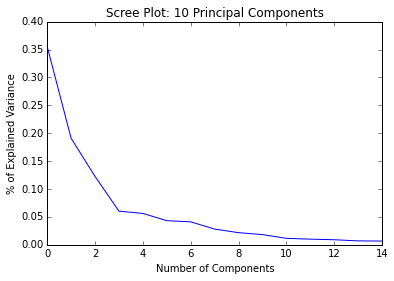

In [17]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf, subsample = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf,
                   subsample = subsample)
    
    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))


space  = [(2, 7),                          # max_depth
          (10**-5, 10**0, "log-uniform"),   # learning_rate
          (5, 7),                           # max_features
          (2, 100),                         # min_samples_split
          (2, 100),                         # min_samples_leaf
          (0.3, 1.0)]                       # subsample

from skopt import gp_minimize

start_time = time.time()
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

print "Best score=%.4f" % res_gp.fun
print('-' * 53)
print '\n%f' % (time.time() - start_time)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- subsample=%.4f""" % (res_gp.x[0], res_gp.x[1],
                       res_gp.x[2], res_gp.x[3],
                       res_gp.x[4], res_gp.x[5]
                      ))


Best score=554.1904
-----------------------------------------------------

179.530961
Best parameters:
- max_depth=7
- learning_rate=0.225245
- max_features=7
- min_samples_split=21
- min_samples_leaf=53
- subsample=1.0000


In [21]:
# Choose the best params from BO results then predict 
# Best parameters:
# - max_depth=7
# - learning_rate=0.225245
# - max_features=7
# - min_samples_split=21
# - min_samples_leaf=53
# - subsample=1.0000

best_max_depth = 7
best_learning_rate = 0.225
best_max_features = 7
best_min_samples_split = 21
best_min_samples_leaf = 53
best_subsample=1.0000
best_pca_gdb = GradientBoostingClassifier(max_depth = best_max_depth,
                                  max_features = best_max_features,
                                  learning_rate = best_learning_rate,
                                  min_samples_split = best_min_samples_split,
                                  min_samples_leaf = best_min_samples_leaf,
                                  subsample = best_subsample)

best_pca_gdb.fit(pca_transformed, train_labels)

# accuracy of trianing dataset
print "Accuracy of best Gradien Boost model on training: %s" % str(best_pca_gdb.score(pca_transformed, train_labels))

# accuracy of testing dataset
print "Accuracy of best Gradien Boost model on testing: %s" % str(best_pca_gdb.score(pca_transformed_test, test_labels))

# use the best params to predict
gdb_pca_true, gdb_pca_pred = test_labels, best_pca_gdb.predict(pca_transformed_test)
gdb_pca_pred

Accuracy of best Gradien Boost model on training: 0.998762988619
Accuracy of best Gradien Boost model on testing: 0.729970326409


array([  24, 1793, 1793, ..., 1793,   24, 1793])

In [23]:
pca_test_data_df = fns.result_table(gdb_true, gdb_pred)
pca_test_data_df = pca_test_data_df.rename(index=str, columns={'predictions': 'grad_boost_pca_pred', 'results': 'grad_boost_pca_res'})
pca_test_data_df

,actual,grad_boost_pca_pred,grad_boost_pca_res
33,24,24,True
34,1793,1793,True
35,1793,1793,True
37,1793,24,False
101,1793,1793,True
102,1793,1793,True
105,1793,1793,True
217,1793,24,False
261,1793,1793,True
295,1793,1793,True


In [25]:
pca_test_data_df.groupby(['actual', 'grad_boost_pca_pred']).aggregate({'grad_boost_pca_res': 'count'}).unstack()

grad_boost_pca_res          
grad_boost_pca_pred               24   368  1793
actual                                          
24                                 252   43   47
368                                 40  248   46
1793                                49   46  240

In [31]:
grad_boost_com = test_data_df.merge(pca_test_data_df, how='inner', on='actual')
grad_boost_com

,actual,grad_boost_pred,grad_boost_res,grad_boost_pca_pred,grad_boost_pca_res
0,24,24,True,24,True
1,24,24,True,24,True
2,24,24,True,24,True
3,24,24,True,368,False
4,24,24,True,24,True
5,24,24,True,24,True
6,24,24,True,24,True
7,24,24,True,24,True
8,24,24,True,1793,False
9,24,24,True,24,True


In [26]:
pca_test_data_df.shape

(1011, 3)

In [27]:
test_data_df.shape

(1011, 3)

In [32]:
grad_boost_com.to_csv('data/grad_boost_com.csv', index=False)